In [2]:
import os
import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

/Users/nysa/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# global paths
gl_labels = "../datasets/webui/train"

gl_lbls = [
    "button",
    "checkbox",
    "container",
    "icon-button",
    "image",
    "input",
    "label",
    "link",
    "number-input",
    "radio",
    "search",
    "select",
    "slider",
    "table",
    "text",
    "textarea",
    "textbox",
    "toggle",
]

class_mapping = dict(zip(range(len(gl_lbls)), gl_lbls))

In [4]:
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(gl_labels, file_name)
        for file_name in os.listdir(gl_labels)
        if file_name.endswith(".xml")
    ]
)


# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(gl_labels, file_name)
        for file_name in os.listdir(gl_labels)
        if file_name.endswith(".jpg")
    ]
)

print(f"Total XML files: {len(xml_files)}"
        f"\nTotal JPEG files: {len(jpg_files)}")

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(gl_labels, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

Total XML files: 1620
Total JPEG files: 1620


  0%|          | 0/1620 [00:00<?, ?it/s]

100%|██████████| 1620/1620 [00:00<00:00, 5536.55it/s]


In [5]:
files = tf.ragged.constant(image_paths)
labels = tf.ragged.constant(classes)
bboxes = tf.ragged.constant(bbox)

files.shape, labels.shape, bboxes.shape

(TensorShape([1620]),
 TensorShape([1620, None]),
 TensorShape([1620, None, None]))

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((files, labels, bboxes))

# Split the dataset into train and validation sets
train_size = int(0.7 * len(dataset))
train_data = dataset.take(train_size)
val_data = dataset.skip(train_size)

BATCH_SIZE = 4
print(len(dataset))
print("Train Size: ", len(train_data))
print("Validation Size: ", len(val_data))

print(train_data)

1620
Train Size:  1134
Validation Size:  486
<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64))>


In [7]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [8]:
bbxf = "xyxy"

In [9]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

In [10]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

In [11]:
augmenters = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=bbxf),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format=bbxf
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format=bbxf
        ),
    ]
)
train_ds = train_ds.map(augmenters, num_parallel_calls=tf.data.AUTOTUNE)
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format=bbxf,
)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

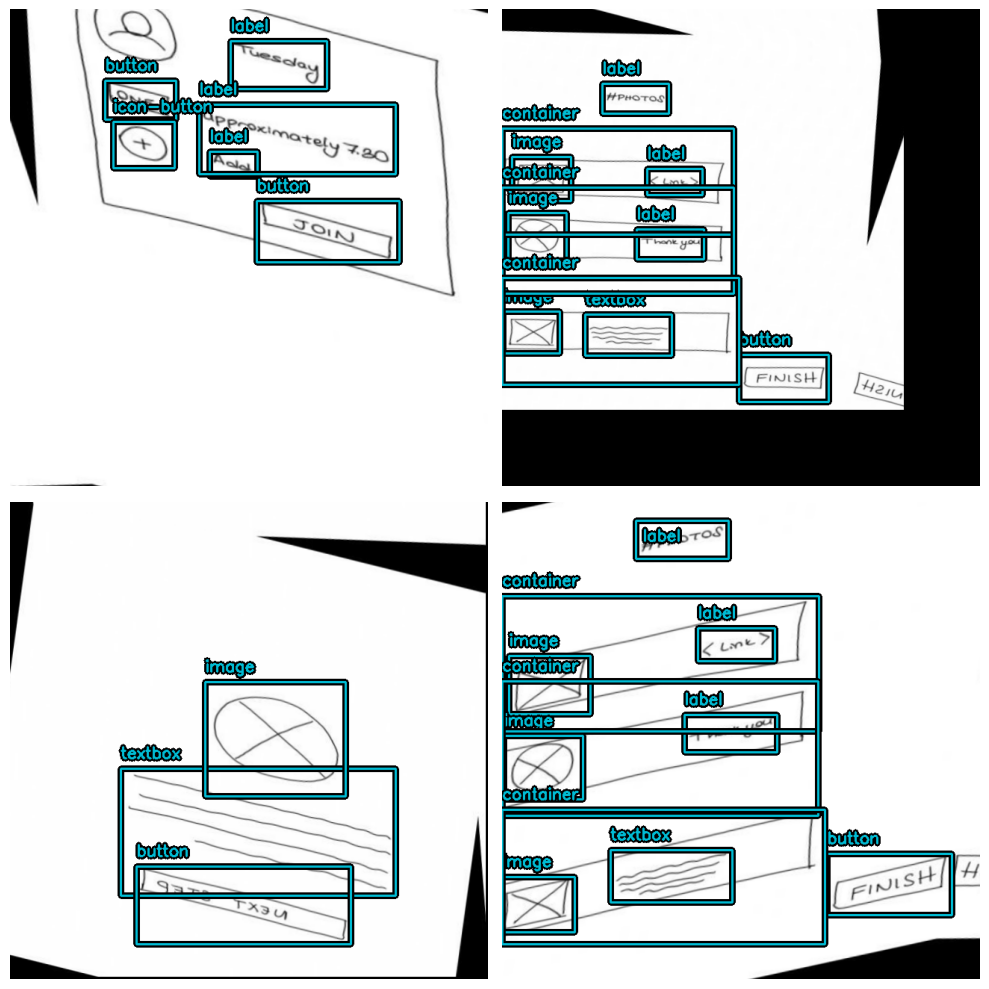

In [12]:
visualize_dataset(
    train_ds,
    bounding_box_format=bbxf,
    value_range=(0, 255),
    rows=2,
    cols=2,
)

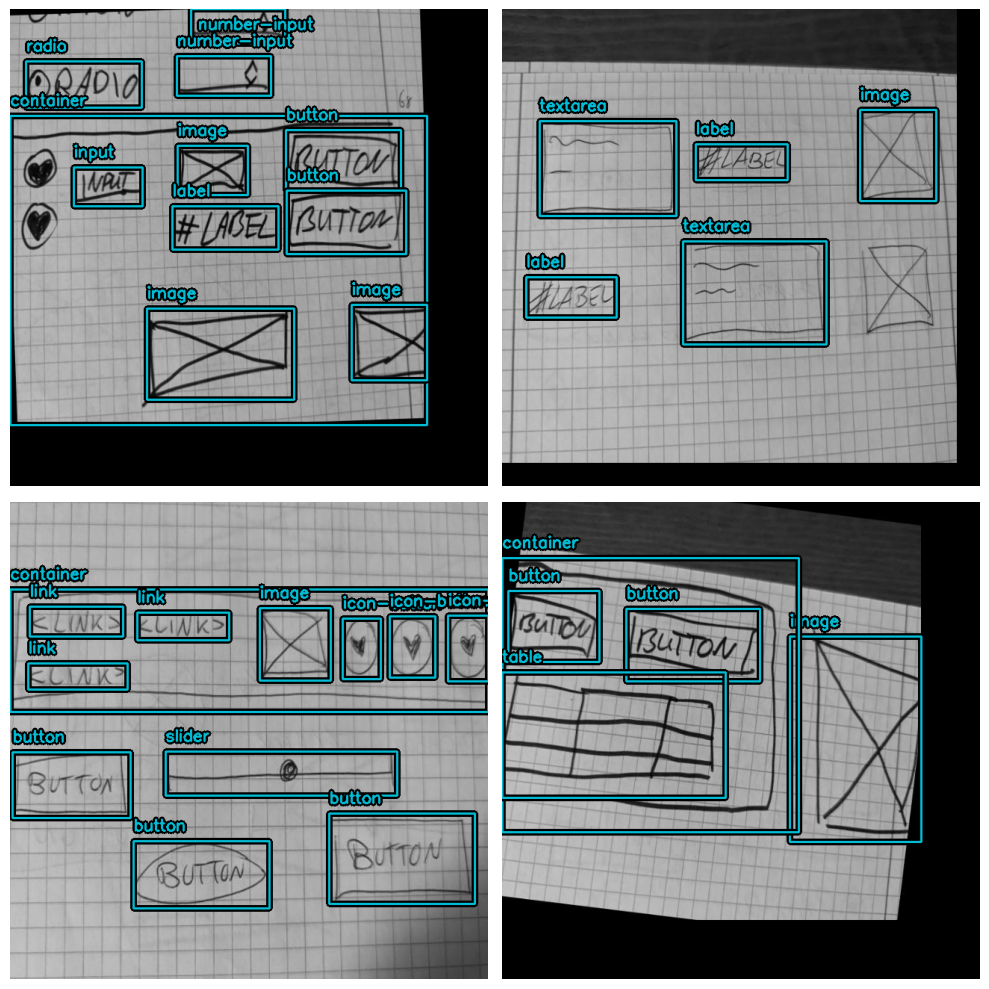

In [13]:
visualize_dataset(
    val_ds,
    bounding_box_format=bbxf,
    value_range=(0, 255),
    rows=2,
    cols=2,
    
)

In [14]:
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [15]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xs_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

In [16]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format=bbxf,
    backbone=backbone,
    fpn_depth=1,
)

# print(yolo.summary())

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [18]:
# get latest saved in freeze folder
RETRAIN = True
if RETRAIN == False:
    import os
    import glob

    list_of_files = glob.glob("freeze/*")
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)

    yolo = keras.models.load_model(latest_file)

callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

with tf.device('/cpu:0'):
    yolo.fit(
        # Run for 10-35~ epochs to achieve good scores.
        train_ds,
        epochs=10,
        callbacks=[callback],
        validation_data=val_ds,
    )

Epoch 1/10


AssertionError: Nesting violated for default stack of <class 'tensorflow.python.framework.func_graph.FuncGraph'> objects

In [ ]:
# save with current timestamp as name
import datetime
time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
yolo.save("freeze/sketch2code_model_" + time + ".keras")

freeze/sketch2code_model_2024-03-24-01-15-44.keras


2024-03-24 01:16:36.221015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{function_node jittered_resize_1_1_map_while_body_2642}}{{node jittered_resize_1_1/map/while/map/while}}]]
2024-03-24 01:16:36.230743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{function_node jittered_resize_1_1_map_while_body_2642}}{{node jittered_resize_1_1/map/while/map/while}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


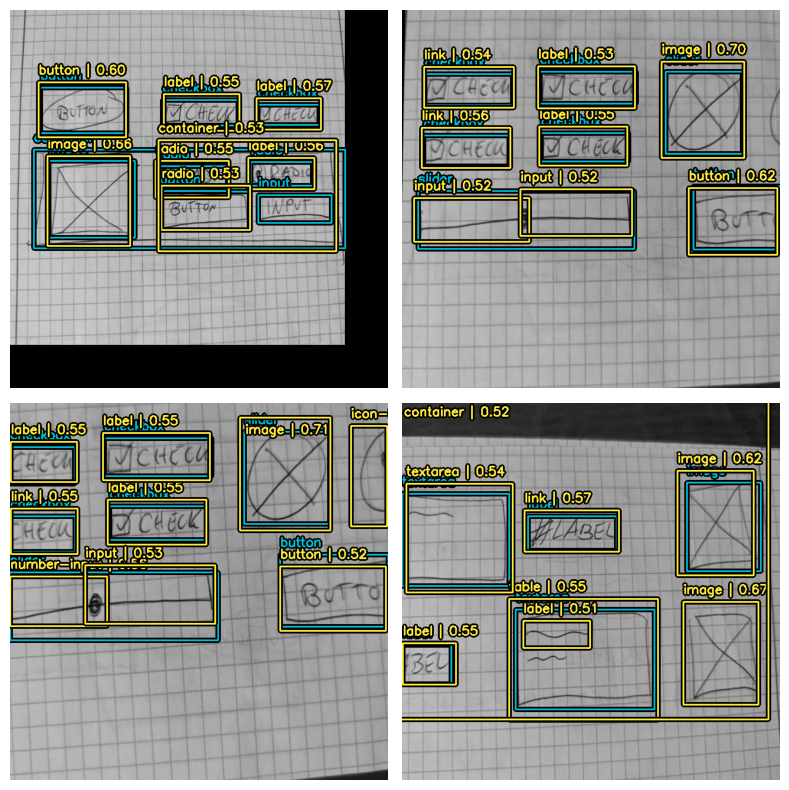

In [ ]:
# get latest saved in freeze folder
import os
import glob
list_of_files = glob.glob('freeze/*')
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

model = keras.models.load_model(latest_file)
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=bbxf,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.51,
)

visualize_detections(model, dataset=val_ds, bounding_box_format=bbxf)